In [1]:
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from fastai.callbacks import *
from fastai.tabular import *

In [2]:
csv_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/color_skeleton+ypr/'
image_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/color_skeleton/im+skeleton/'

class_names = ['selfie', 'non_selfie', 'mirror_selfie', 'non_mirror_selfie']

class_dataframes = {}

for class_name in class_names:
    csv = pd.read_csv(csv_path+class_name+'.csv')
    csv.insert(0, column = 'class_label',value = len(csv.index)*[f"{class_name}"])
    csv['path'] = csv.class_label + '/' + csv.filename
    csv = csv.drop(['filename'], axis = 1)
    class_dataframes[class_name] = csv

In [3]:
[class_dataframe.shape for _, class_dataframe in class_dataframes.items()] 

[(1789, 10), (1260, 10), (1266, 10), (1439, 10)]

In [4]:
class_dataframes.keys()

dict_keys(['selfie', 'non_selfie', 'mirror_selfie', 'non_mirror_selfie'])

In [5]:
class_dataframes[class_names[3]].shape

(1439, 10)

In [6]:
selfie_df = class_dataframes['selfie'].sample(n=len(class_dataframes['non_selfie'].index), replace=False, random_state=4, axis=0)

print(selfie_df.shape)
#newdf = class_dataframes['selfie'].copy().append(class_dataframes['non_selfie'])
newdf = selfie_df.append(class_dataframes['non_selfie'])

(1260, 10)


In [7]:
print(newdf.shape)
newdf.head()

(2520, 10)


,class_label,x_min,y_min,x_max,y_max,confidence_score,yaw,pitch,roll,path
1255,selfie,138.125977,0.584160,258.079865,140.086243,NaN,-0.641205,-4.237106,-0.695053,selfie/bing_selfie_pastmonth_000387.jpg_im_ske...
1758,selfie,80.503311,81.839630,205.567429,242.020813,NaN,-1.656120,-22.516785,-5.354843,selfie/selfie_mshah_0000260.jpg_im_skeleton.jpg
1226,selfie,96.760376,37.433884,217.585358,203.770584,NaN,-7.906647,3.850571,5.562355,selfie/selfie_mshah_0003528.jpg_im_skeleton.jpg
554,selfie,90.119972,78.243149,234.852600,271.807312,NaN,6.548569,0.761742,6.543167,selfie/selfie_mshah_0038357.jpg_im_skeleton.jpg
230,selfie,94.707085,74.440269,213.292572,216.627594,NaN,3.877739,6.659058,0.466476,selfie/selfie_tag_11316283405_d8fd776a2b_c.jpg...


In [8]:
def _normalize_images_batch(b:Tuple[Tensor,Tensor], mean:FloatTensor, std:FloatTensor)->Tuple[Tensor,Tensor]:
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
    x,y = b
    mean,std = mean.to(x[0].device),std.to(x[0].device)
    x[0] = normalize(x[0],mean,std)
    return x,y

def normalize_custom_funcs(mean:FloatTensor, std:FloatTensor, do_x:bool=True, do_y:bool=False)->Tuple[Callable,Callable]:
    "Create normalize/denormalize func using `mean` and `std`, can specify `do_y` and `device`."
    mean,std = tensor(mean),tensor(std)
    return (partial(_normalize_images_batch, mean=mean, std=std),
            partial(denormalize, mean=mean, std=std))

In [9]:
imgList = ImageList.from_df(newdf, path=image_path, cols='path')

In [10]:
tabList = TabularList.from_df(newdf, cat_names=[], cont_names=['yaw','pitch','roll'], procs=[Normalize])


In [11]:
mixed = MixedItemList([imgList, tabList], image_path, inner_df=imgList.inner_df)\
.split_by_rand_pct(.2)\
.label_from_df(cols='class_label')
#.transform([[get_transforms()[0], []], [get_transforms()[1], []]], size=224)

data = mixed.databunch(no_check=True, bs=64, num_workers=0) # num_workers=0 here just to get errors more quickly

In [12]:
data.classes

['non_selfie', 'selfie']

In [13]:
norm, denorm = normalize_custom_funcs(*imagenet_stats)
data.add_tfm(norm) # normalize images

In [14]:
item, labels = next(iter(data.train_dl))

In [15]:
# item[1][0], item[1][1]
mixed.train.x.item_lists[1].get_emb_szs()

[]

In [16]:
print(*imagenet_stats)

[0.485, 0.456, 0.406] [0.229, 0.224, 0.225]


In [17]:
emb = mixed.train.x.item_lists[1].get_emb_szs()

In [19]:
# from fastai.torch_core import *
# from fastai.vision import *
# from fastai.tabular.models import *
# from fastai.tabular import *
# from fastai.layers import *
# import torch

# class ImageTabularModel(nn.Module):
#     "Basic model for tabular data."
#     def __init__(self, emb_szs:ListSizes, n_cont:int, layers:Collection[int], ps:Collection[float]=None):
#         super().__init__()
#         self.cnn = create_body(models.resnet34)
#         self.tab = TabularModel({}, n_cont, 128, [512, 356]) #TabularModel(emb_szs, n_cont, 512, layers, ps)

#         self.reduce = nn.Sequential(*([Flatten()] + bn_drop_lin((512*7*7), 512, bn=True, p=0.5, actn=nn.ReLU(inplace=True))))
#         self.merge = nn.Sequential(*bn_drop_lin(512 + 512, 1024, bn=True, p=0.5, actn=nn.ReLU(inplace=True)))
#         self.final = nn.Sequential(*bn_drop_lin(1024, 2, bn=True, p=0., actn=nn.ReLU(inplace=True)))

#     def forward(self, img:Tensor, x_cat:Tensor, x_cont:Tensor) -> Tensor:
#         imgLatent = self.reduce(self.cnn(img))
#         tabLatent = self.tab(x_cat, x_cont)

#         cat = torch.cat(imgLatent, tabLatent)

#         return self.final(self.merge(cat))

In [20]:
def split_layers(model:nn.Module) -> List[nn.Module]:
    groups = [[model.cnn]]
    groups += [[model.tab, model.reduce, model.merge, model.final]]
    return groups

class ImageTabularTextLearner(Learner):
    def __init__(self, data:DataBunch, model:nn.Module, alpha:float=2., beta:float=1., **learn_kwargs):
        super().__init__(data, model, **learn_kwargs)
        self.split(split_layers)

In [21]:
class ImageTabularTextModel(nn.Module):
    def __init__(self, n_cont:int):
        super().__init__()
        self.cnn = create_body(models.resnet34)
        nf = num_features_model(self.cnn) * 2
        drop = .5

        self.tab = TabularModel({}, n_cont, 128, [512, 256])

        self.reduce = nn.Sequential(*([AdaptiveConcatPool2d(), Flatten()] + bn_drop_lin(nf, 512, bn=True, p=drop, actn=nn.ReLU(inplace=True))))
        self.merge = nn.Sequential(*bn_drop_lin(512 + 128, 128, bn=True, p=drop, actn=nn.ReLU(inplace=True)))
        self.final = nn.Sequential(*bn_drop_lin(128, 2, bn=False, p=0., actn=None))
        #self.final = nn.Sequential(*bn_drop_lin(512, 2, bn=False, p=0., actn=None))
        #print(self)
        
    def forward(self, img:Tensor, x:Tensor) -> Tensor:
        #print(img.shape)        
        imgCnn = self.cnn(img)
        #print(imgCnn.shape)
        imgLatent = self.reduce(imgCnn)
        #print(imgLatent.shape)
        tabLatent = self.tab(x[0], x[1])
        #print(tabLatent.shape)
        
        cat = torch.cat([imgLatent, F.relu(tabLatent)], dim=1)
        #print(cat.shape)
        
        pred = self.final(self.merge(cat))
        #pred = torch.sigmoid(pred)  # making sure this is in the range 0-4
        #pred = torch.sigmoid(self.final(self.reduce(imgCnn)))
        #print(pred)
        return pred #torch.softmax(torxh.zeros(1,2))
        
    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()

In [22]:
model = ImageTabularTextModel(3)
learn = ImageTabularTextLearner(data, model, metrics=[error_rate])

In [23]:
# it = iter(data.valid_dl)
# for item, label in it:
#     print(label)

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


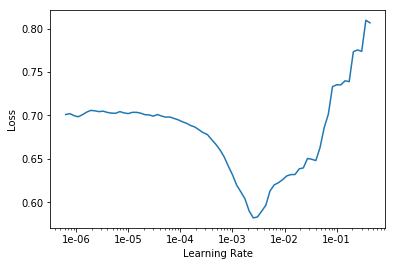

In [25]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(10, .4e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.661677,0.596859,0.230159,00:08
1,0.450733,0.312946,0.123016,00:08
2,0.285254,1.243006,0.251984,00:08
3,0.199535,0.367151,0.123016,00:08
4,0.157683,0.302446,0.113095,00:08
5,0.101708,0.312191,0.101190,00:08
6,0.060749,0.338563,0.091270,00:08
7,0.035290,0.331052,0.083333,00:08
8,0.021332,0.331242,0.079365,00:08
9,0.012520,0.338467,0.077381,00:08


In [27]:
learn.save('resnet34_stage_1_im_sk_ypr')
# learn.fit_one_cycle(5, .7e-3)
learn.load('resnet34_stage_1_im_sk_ypr');

In [28]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


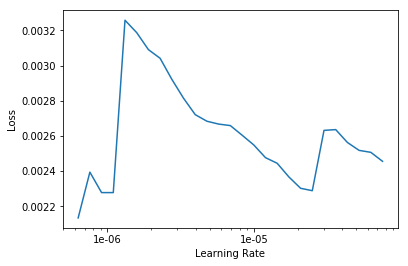

In [30]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(10, max_lr=slice(1.1e-6,1.1e-6/3))

epoch,train_loss,valid_loss,error_rate,time
0,0.002844,0.332292,0.081349,00:08
1,0.002357,0.336318,0.075397,00:08
2,0.002849,0.337650,0.077381,00:08
3,0.002496,0.332626,0.075397,00:08
4,0.002366,0.346405,0.081349,00:08
5,0.002270,0.338228,0.075397,00:08
6,0.001998,0.338042,0.073413,00:08
7,0.002699,0.329835,0.079365,00:08
8,0.002751,0.336366,0.075397,00:08
9,0.002191,0.336229,0.075397,00:08


In [32]:
interp = ClassificationInterpretation.from_learner(learn)

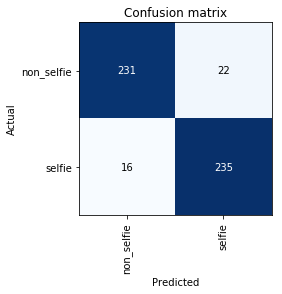

In [33]:
interp.plot_confusion_matrix()

In [34]:
confusion_mat = interp.confusion_matrix()
confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1)

array([[0.913043, 0.086957],
       [0.063745, 0.936255]])

In [57]:
len(data.train_ds), len(data.valid_ds)

(2440, 609)